# Structured Output and Custom Tools

## Structured Output

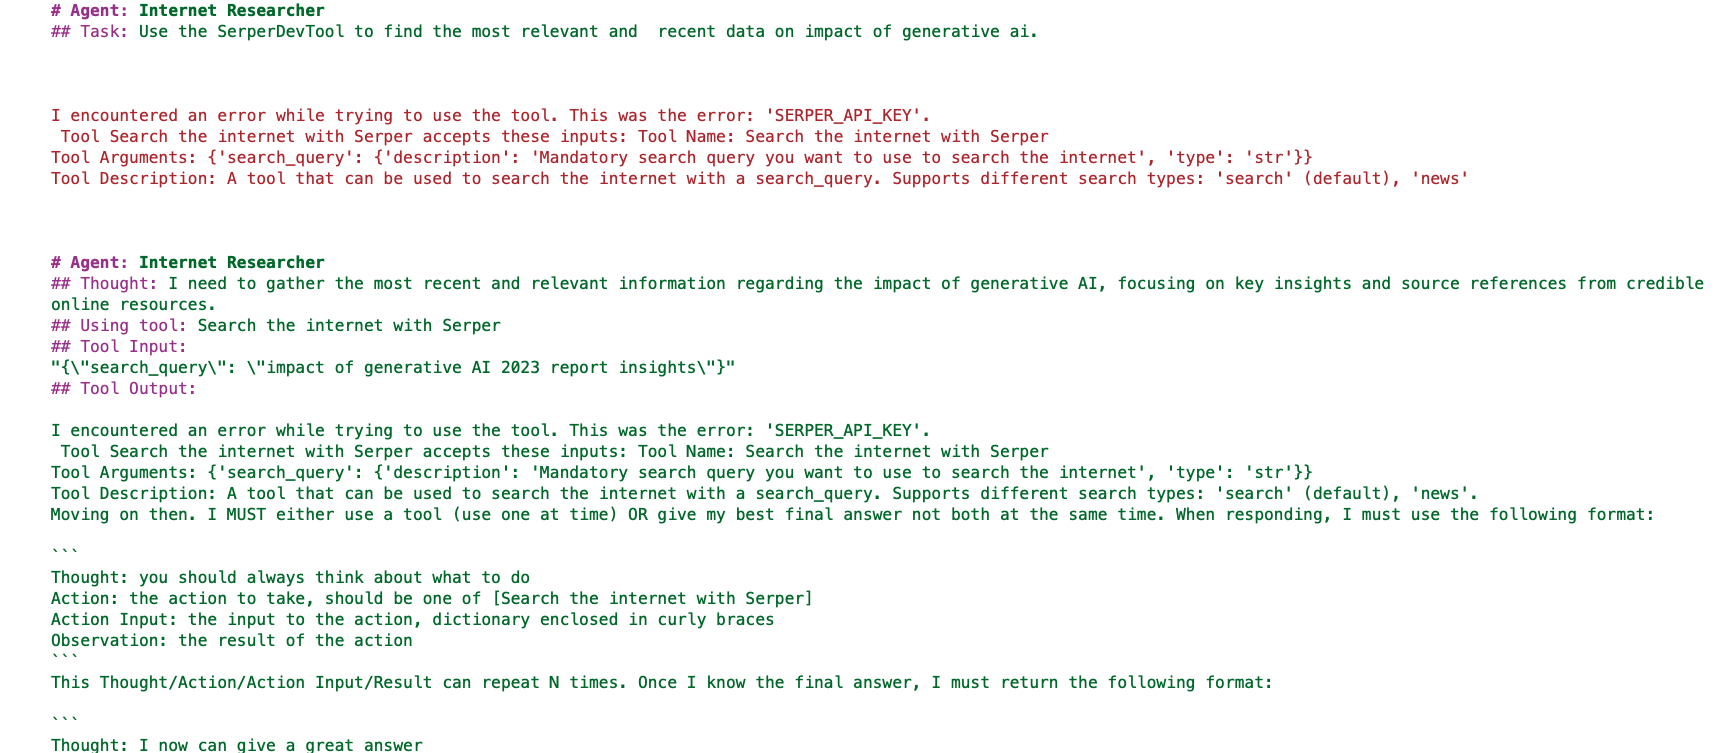

Kenapa butuh structured output

- Butuh output yang predictable dan konsisten untuk setiap run-nya

- Automation tanpa cleanup

- integrasi ke API atau database

- fixed structured untuk ekstraksi insight

In [88]:
# .env

# OPENAI_API_KEY=
# EXCHANGE_RATE_API_KEY=

In [89]:
from dotenv import load_dotenv

load_dotenv()

True

In [91]:
from crewai import Agent

agent = Agent(
    role="Senior Linguist",
    goal="Analzse the query and extract entity-relation-entity information",
    backstory="You are a senior linguist that is known for your analytical skills.",
    verbose=True
)

In [92]:
from crewai import Task

task = Task(
    description="""Analyse the query and return structured JSON
                   output in the form of
                   - entity1
                   - relation
                   - entity2

                   The query is: {query}
                   """,
    expected_output="A structured JSON object with the entity-relation-entity data",
    verbose=True,
    agent=agent
)

In [93]:
from crewai import Crew, Process

crew = Crew(
    agents=[agent],
    tasks=[task],
    process=Process.sequential,
    verbose=True
)

Overriding of current TracerProvider is not allowed


In [94]:
response = crew.kickoff(inputs={"query":"""Jakarta is the capital of Indonesia."""})

# Agent: Senior Linguist
## Task: Analyse the query and return structured JSON
                   output in the form of
                   - entity1
                   - relation
                   - entity2

                   The query is: Jakarta is the capital of Indonesia.
                   


# Agent: Senior Linguist
## Final Answer: 
```json
{
  "entity1": "Jakarta",
  "relation": "is the capital of",
  "entity2": "Indonesia"
}
```




In [95]:
print(response.raw)

```json
{
  "entity1": "Jakarta",
  "relation": "is the capital of",
  "entity2": "Indonesia"
}
```


In [96]:
from pydantic import BaseModel, Field

class EntityRelationEntity(BaseModel):
    entity1: str = Field(description="The first entity in the triplet")
    relation: str = Field(description="The relation between the first and second entity")
    entity2: str = Field(description="The second entity in the triplet")

In [97]:
from crewai import Agent

agent = Agent(
    role="Senior Linguist",
    goal="Analyse the query and extract entity-relation-entity data",
    backstory="You are a senior linguist that is known for your analytical skills.",
    verbose=True
)

In [99]:
from crewai import Task

task = Task(
    description="""Analyse the query and return structured JSON
                   output in the form of
                   - entity1
                   - relation
                   - entity2

                   The query is: {query}
                   """,
    expected_output="""A structured JSON object with the
                       entity-relation-entity data""",
    output_pydantic=EntityRelationEntity,
    verbose=True,
    agent=agent
)

In [100]:
from crewai import Crew, Process

crew = Crew(
    agents=[agent],
    tasks=[task],
    process=Process.sequential,
    verbose=True
)

response = crew.kickoff(inputs={"query": "Jakarta is the capital of Indonesia"})

Overriding of current TracerProvider is not allowed


# Agent: Senior Linguist
## Task: Analyse the query and return structured JSON
                   output in the form of
                   - entity1
                   - relation
                   - entity2

                   The query is: Jakarta is the capital of Indonesia
                   


# Agent: Senior Linguist
## Final Answer: 
{
  "entity1": "Jakarta",
  "relation": "is the capital of",
  "entity2": "Indonesia"
}




In [101]:
print(response.raw)

{
  "entity1": "Jakarta",
  "relation": "is the capital of",
  "entity2": "Indonesia"
}


In [103]:
eval(response.raw)

{'entity1': 'Jakarta', 'relation': 'is the capital of', 'entity2': 'Indonesia'}

## Custom Tools

Free API: https://app.exchangerate-api.com/

User: "Jika saya punya uang 1000000 rupiah, berapa nilainya jika ditukarkan dengan Japan Yen?"

In [104]:
from dotenv import load_dotenv
load_dotenv()
import os
import requests
from typing import Type
from crewai.tools import BaseTool
from pydantic import BaseModel, Field

In [105]:
class CurrencyConverterInput(BaseModel):
    amount: float = Field(..., description="The amount to convert.")
    from_currency: str = Field(..., description="The source currency code (e.g., 'USD').")
    to_currency: str = Field(..., description="The target currency code (e.g., 'EUR').")

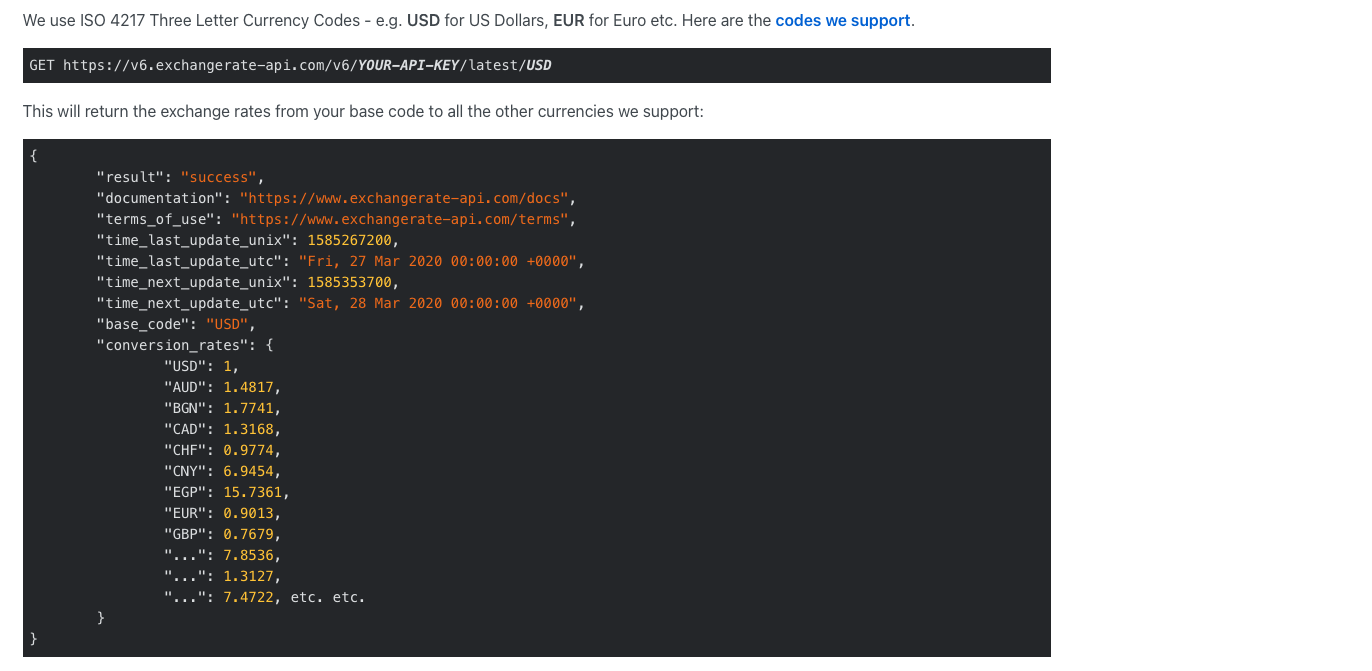

In [106]:
class CurrencyConverterTool(BaseTool):
    name: str = "Currency Converter Tool"
    description: str = "Converts an amount from one currency to another using live exchange rates."
    args_schema: Type[BaseModel] = CurrencyConverterInput
    api_key: str = os.getenv("EXCHANGE_RATE_API_KEY")

    def _run(self, amount: float, from_currency: str, to_currency: str) -> str:
        url = f"https://v6.exchangerate-api.com/v6/{self.api_key}/latest/{from_currency}"
        response = requests.get(url)
        if response.status_code != 200:
            return "Failed to fetch exchange rates."

        data = response.json()
        if "conversion_rates" not in data or to_currency not in data["conversion_rates"]:
            return f"Invalid currency code: {to_currency}"

        rate = data["conversion_rates"][to_currency]
        converted_amount = amount * rate
        return f"{amount} {from_currency} is equivalent to {converted_amount:.2f} {to_currency}."

In [107]:
from crewai import Agent

currency_analyst = Agent(
    role="Currency Analyst",
    goal="Provide real-time currency conversions and financial insights.",
    backstory=(
        "You are a finance expert with deep knowledge of global exchange rates."
        "You help users with currency conversion and financial decision-making."
    ),
    tools=[CurrencyConverterTool()],
    verbose=True
)

In [108]:
from crewai import Task

currency_conversion_task = Task(
    description=(
        "Convert {amount} {from_currency} to {to_currency} "
        "using real-time exchange rates."
        "Provide the equivalent amount and "
        "explain any relevant financial context."
    ),
    expected_output=("A detailed response including the "
                     "converted amount and financial insights."),
    agent=currency_analyst
)

In [109]:
from crewai import Crew, Process

crew = Crew(
    agents=[currency_analyst],
    tasks=[currency_conversion_task],
    process=Process.sequential
)

response = crew.kickoff(inputs={"amount": 1, 
                                "from_currency": "USD",
                                "to_currency": "IDR"})


Overriding of current TracerProvider is not allowed


# Agent: Currency Analyst
## Task: Convert 1 USD to IDR using real-time exchange rates.Provide the equivalent amount and explain any relevant financial context.


# Agent: Currency Analyst
## Using tool: Currency Converter Tool
## Tool Input: 
"{\"amount\": 1, \"from_currency\": \"USD\", \"to_currency\": \"IDR\"}"
## Tool Output: 
1.0 USD is equivalent to 16377.88 IDR.


# Agent: Currency Analyst
## Final Answer: 
1 USD is equivalent to approximately 16,377.88 IDR. 

In terms of financial context, the Indonesian Rupiah (IDR) has historically experienced fluctuations against the US Dollar (USD). Various factors, including Indonesia's economic performance, inflation rates, interest rates, and global market conditions can influence the exchange rate. Additionally, while the IDR may be low against the USD, it is essential to consider purchasing power parity and the cost of living in Indonesia when assessing the impact of currency conversion on financial decisions.




## Latihan

In [23]:
class CurrencyConverterInput(BaseModel):
    amount: float = Field(..., description="The amount to convert.")
    from_currency: str = Field(..., description="The source currency code (e.g., 'USD').")
    to_currency: str = Field(..., description="The target currency code (e.g., 'EUR').")

In [110]:
query_analyst = Agent(
    role="Query Analyst",
    goal="Analyze the user's query and output a structured response containing the amount, from_currency, and to_currency. The query is: '{query}'.",
    backstory=(
        "You are a language understanding expert with background in finance."
        "You understand the user's natural language query and output a structured response containing the amount, from_currency, and to_currency."
    ),
    verbose=True
)

query_task = Task(
    description="Understand the user's natural language query and extract the total amount, source currency, and target currency. The query is: '{query}'.",
    expected_output="A structured response to the user's query.",
    agent=query_analyst,
    output_pydantic=CurrencyConverterInput,
)

In [112]:
currency_analyst = Agent(
    role="Currency Analyst",
    goal="Provide real-time currency conversions and financial insights.",
    backstory=(
        "You are a finance expert with deep knowledge of global exchange rates."
        "You help users with currency conversion and financial decision-making."
    ),
    tools=[CurrencyConverterTool()],
    verbose=True
)

currency_conversion_task = Task(
    description=(
        "Accept the output from the query analyst agent and convert the amount using real-time exchange rates."
        "The input will contain the amount, from_currency, and to_currency."
        "Provide the equivalent amount and explain any relevant financial context."
    ),
    expected_output="A detailed response including the converted amount and financial insights.",
    agent=currency_analyst
)

In [113]:
crew = Crew(
    agents=[query_analyst, currency_analyst],
    tasks=[query_task, currency_conversion_task],
    process=Process.sequential
)

response = crew.kickoff(inputs={"query": "I am traveling to Japan from Indonesia, I have 10000000 of local currency, how much of Japaese currency will I be able to get?"})

Overriding of current TracerProvider is not allowed


# Agent: Query Analyst
## Task: Understand the user's natural language query and extract the total amount, source currency, and target currency. The query is: 'I am traveling to Japan from Indonesia, I have 10000000 of local currency, how much of Japaese currency will I be able to get?'.


# Agent: Query Analyst
## Final Answer: 
{
  "amount": 10000000,
  "from_currency": "IDR",
  "to_currency": "JPY"
}


# Agent: Currency Analyst
## Task: Accept the output from the query analyst agent and convert the amount using real-time exchange rates.The input will contain the amount, from_currency, and to_currency.Provide the equivalent amount and explain any relevant financial context.


# Agent: Currency Analyst
## Using tool: Currency Converter Tool
## Tool Input: 
"{\"amount\": 10000000, \"from_currency\": \"IDR\", \"to_currency\": \"JPY\"}"
## Tool Output: 
10000000.0 IDR is equivalent to 89860.00 JPY.


# Agent: Currency Analyst
## Final Answer: 
The conversion of 10,000,000 Indonesian Rupi